In [1]:
import glob
import os
import sys
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from multiprocessing import Process
import gc

import tensorflow as tf
import sklearn
import time

import numpy as np
import pandas as pd
from pandas import DataFrame

#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2024-02-23 16:53:56.260252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 16:53:56.407279: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 16:53:56.981962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-23 16:53:56.982043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# argumentos
n = len(sys.argv)
print("Total arguments passed:", n)
iteracoes = 0
cycle_index = 1
finalIterations = 0
if(n > 0):
    for value in sys.argv:
        print("arg:", value)
        if("iterations=" in value):
            try:
                iteracoes = int(value.replace("iterations=",""))
            except:
                print("no")
        
        if("cycle=" in value):
            try:
                cycle_index = int(value.replace("cycle=",""))
            except:
                print("no")
print("iteracoes:",iteracoes)      
print("cycle:",cycle_index)

Total arguments passed: 3
arg: /home/guilherme/cpu-tensorflow-marcelo/nvidia-smi/envs/flower/lib/python3.9/site-packages/ipykernel_launcher.py
arg: -f
arg: /home/guilherme/.local/share/jupyter/runtime/kernel-0ebdb1a0-dd89-4fdd-975f-16c694fbbaf3.json
iteracoes: 0
cycle: 1


In [3]:

cycles = [0,1,2]
cycles = [0,1]
iteracoes = 200
print("iteracoes:",iteracoes)
print("cycles:",cycles)

iteracoes: 200
cycles: [0, 1]


In [4]:
# input folder
#inputFolders = "../02-transformed-data-new-testes/dados2019/"
inputFolderPath = "../data_2019_processed/"

# General configuration
NUMBER_OF_ITERATIONS_FINAL = 200
    
NUM_EPOCHS = 1
BATCH_SIZE = 32
VERBOSE = 0


# usado para checkpoints
if(iteracoes > 0):
    NUMBER_OF_ITERATIONS_FINAL = iteracoes
    
NUMBER_OF_ITERATIONS = NUMBER_OF_ITERATIONS_FINAL

# train file name modifier
fileSufixTrain = "" # _smote for smote

#fl.common.logger.configure(identifier="myFlowerExperiment", filename="log_"+outputFolder+".txt")

In [5]:
# selected features
inputFeatures = ["activity","location","day_of_week","light","phone_lock","proximity","sound","time_to_next_alarm", "minutes_day"]
outputClasses = ["awake","asleep"]
#outputClasses = ["class"]

In [6]:
# client datasets used on the training process (75% of data)
trainFolders =  ['0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                '0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                '2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                '2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                '7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                #'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                #'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4']
                #'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                #'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                #'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                #'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                #'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                #'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']
            
# client datasets used on the training process (25% of data)
testFolders =  [#'0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                #'0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                #'2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                #'2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                #'7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                #'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                #'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                #'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                #'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                #'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                #'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                #'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                #'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                #'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                #'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                #'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                #'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                #'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                #'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4'] 
                'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']

In [7]:
def generateMetrics(y_test,yhat_probs):
    # predict crisp classes for test set deprecated
    #yhat_classes = model.predict_classes(X_test, verbose=0)
    #yhat_classes = np.argmax(yhat_probs,axis=1)
    yhat_classes = yhat_probs.round()
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    #print(matrix)
    
    array = []
    results = dict()
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1_score'] = f1
    results['cohen_kappa_score'] = kappa
    results['roc_auc_score'] = auc
    results['matrix'] = ("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    results['TP'] = matrix[0][0]
    results['FP'] = matrix[0][1]
    results['FN'] = matrix[1][0]
    results['TN'] = matrix[1][1]
    
    array.append(accuracy)
    array.append(precision)
    array.append(recall)
    array.append(f1)
    array.append(kappa)
    array.append(auc)
    array.append("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    array.append(matrix[0][0]) # TP
    array.append(matrix[0][1]) # FP
    array.append(matrix[1][0]) # FN
    array.append(matrix[1][1]) # TN
    
    return results, array

# y_test     = Array with real values
# yhat_probs = Array with predicted values
def printMetrics(y_test,yhat_probs):
    # generate metrics
    results, array= generateMetrics(y_test,yhat_probs)

    # accuracy: (tp + tn) / (p + n)
    accuracy = results['accuracy']
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = results['precision']
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = results['recall'] 
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = results['f1_score']
    print('F1 score: %f' % f1)
    # kappa
    kappa = results['cohen_kappa_score']
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = results['roc_auc_score']
    print('ROC AUC: %f' % auc)
    # confusion matrix
    print("\Confusion Matrix")
    matrix = results['matrix']
    print(matrix)
    
    return results, array

def generateGlobalMetrics(metrics):
    accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score = 0,0,0,0,0,0
    for metric in metrics:
        accuracy = accuracy + metric['accuracy']
        precision = precision + metric['precision']
        recall = recall + metric['recall']
        f1_score = f1_score + metric['f1_score']
        cohen_kappa_score = cohen_kappa_score + metric['cohen_kappa_score']
        roc_auc_score = roc_auc_score + metric['roc_auc_score']
        
    # mean
    size = len(metrics)
    print(size)
    accuracy = accuracy / size
    precision = precision / size
    recall = recall / size
    f1_score = f1_score / size
    cohen_kappa_score = cohen_kappa_score / size
    roc_auc_score = roc_auc_score / size
    
    return [accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score]

def showGlobalMetrics(metrics):
    res = generateGlobalMetrics(metrics)
    
    accuracy = res[0]
    precision = res[1]
    recall = res[2]
    f1_score = res[3]
    cohen_kappa_score = res[4]
    roc_auc_score = res[5]
    
    #show:\
    print("accuracy: ",accuracy)
    print("precision: ",precision)
    print("recall: ",recall)
    print("f1_score: ",f1_score)
    print("cohen_kappa_score: ",cohen_kappa_score)
    print("roc_auc_score: ",roc_auc_score)
    
    return res

In [8]:
# take the list of directories and concat them
def loadDataFromFolders(foldersToLoad,inputFolders,fileType = ""):
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        #print(trainingDataSet[i])
        if(i == 0):
            temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        else:
            dataset = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
            temp_data = pd.concat([temp_data, dataset])
    # return the dataset        
    return temp_data

# take the list of directories and concat them
def loadDataFromFoldersOnList(foldersToLoad,inputFolders,fileType = ""):
    clientList = []
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        #print(trainingDataSet[i])
        temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        print("Adding to the list: ", temp_data.shape)
        clientList.append(temp_data)
    # return the dataset        
    return clientList

def loadDataFromLastCycleFoldersOnList(iferredCycleDataFolder):
    clientList = []
    foldersToLoad = trainFolders
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,iferredCycleDataFolder+"/student_"+currentFolder+".csv")
        #print(trainingDataSet[i])
        temp_data = pd.read_csv(iferredCycleDataFolder+"/student_"+currentFolder+".csv")
        temp_data['class'] = temp_data['awake']
        temp_data['class'] = temp_data['class'].astype('int32')
        
        mapper = {0: 'asleep', 1: 'awake'}

        temp_data['class'] = temp_data['class'].map(mapper)
        #temp_data['class'] = temp_data['class'].apply(lambda tpl: [mapper.get(x) for x in tpl])

        #temp_data['fullcoursenames'] = [[mapper.get(x) for x in tpl] for tpl in temp_data['itemsets']]

        #del temp_data['awake']
        #del temp_data['asleep']
        
        print("Adding to the list: ", temp_data.shape)
        clientList.append(temp_data)
    # return the dataset        
    return clientList

Load datasets

In [9]:
print("Preparing test data")
 
# test data comprising 25% of the data. It must be fixed to all models being evaluated
#X_test  = pd.read_csv(inputFolders+"test/allData-classification-numeric-normalized.csv")
X_test = loadDataFromFolders(testFolders,inputFolderPath,"")

print()
# undestand the dataset by looking on their infos
print(X_test.info())

X_test

Preparing test data
8 datasets
0 - rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw ../data_2019_processed/student_rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw_transformed.csv
1 - RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI ../data_2019_processed/student_RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI_transformed.csv
2 - VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is ../data_2019_processed/student_VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is_transformed.csv
3 - Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw ../data_2019_processed/student_Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw_transformed.csv
4 - XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA ../data_2019_processed/student_XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA_transformed.csv
5 - YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw ../data_2019_processed/student_YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw_transformed.csv
6 - ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM ../data_2019_processed/student_ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM_transformed.csv


activity  location     timestamp  time_to_next_alarm     sound  \
0          0.75       1.0  0.000000e+00            0.000000  0.515992   
1          0.25       1.0  3.211282e-07            0.000000  0.542171   
2          0.25       1.0  6.422564e-07            0.000000  0.515992   
3          0.00       1.0  6.422564e-07            0.000000  0.515992   
4          0.25       1.0  6.422564e-07            0.000000  0.531341   
...         ...       ...           ...                 ...       ...   
13208      1.00       0.0  3.981050e-03            0.923909  0.577338   
13209      1.00       0.0  3.981050e-03            0.923809  0.612109   
13210      0.00       0.0  3.981371e-03            0.923611  0.573415   
13211      0.75       0.0  3.981693e-03            0.923611  0.538685   
13212      0.75       0.0  3.981693e-03            0.923512  0.542238   

       proximity  phone_lock     light  day_of_week  minutes_day  \
0            1.0         0.0  0.000000          1.0     0.678249   
1            0.0         1.0  0.000007          1.0     0.678944   
2            0.0         1.0  0.000000          1.0     0.679639   
3            0.0         1.0  0.000000          1.0     0.680334   
4            0.0         1.0  0.000000          1.0     0.681028   
...          ...         ...       ...          ...          ...   
13208        1.0         0.0  0.000266          1.0     0.035441   
13209        1.0         0.0  0.000236          1.0     0.036136   
13210        1.0         0.0  0.000118          1.0     0.037526   
13211        1.0         0.0  0.000089          1.0     0.037526   
13212        1.0         0.0  0.000030          1.0     0.038221   

                  timestamp_text  class  
0      2018-05-14 16:16:08+00:00  awake  
1      2018-05-14 16:17:39+00:00  awake  
2      2018-05-14 16:18:39+00:00  awake  
3      2018-05-14 16:19:09+00:00  awake  
4      2018-05-14 16:20:09+00:00  awake  
...                          ...    ...  
13208  2018-06-05 00:51:21+00:00  awake  
13209  2018-06-05 00:52:21+00:00  awake  
13210  2018-06-05 00:54:11+00:00  awake  
13211  2018-06-05 00:54:41+00:00  awake  
13212  2018-06-05 00:55:42+00:00  awake  

[110603 rows x 12 columns]

In [10]:
# one-hot encoding function
def transform_output_nominal_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data['awake']
    dataset['asleep'] = one_hot_encoded_data['asleep']
    
    return dataset

# one-hot encoding function
def transform_output_numerical_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data[0]
    dataset['asleep'] = one_hot_encoded_data[1]
    
    return dataset

# transform output to one_hot_encoding for the testing dataset
X_test = transform_output_nominal_class_into_one_hot_encoding(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110603 entries, 0 to 13212
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            110603 non-null  float64
 1   location            110603 non-null  float64
 2   timestamp           110603 non-null  float64
 3   time_to_next_alarm  110603 non-null  float64
 4   sound               110603 non-null  float64
 5   proximity           110603 non-null  float64
 6   phone_lock          110603 non-null  float64
 7   light               110603 non-null  float64
 8   day_of_week         110603 non-null  float64
 9   minutes_day         110603 non-null  float64
 10  timestamp_text      110603 non-null  object 
 11  class               110603 non-null  object 
 12  awake               110603 non-null  bool   
 13  asleep              110603 non-null  bool   
dtypes: bool(2), float64(10), object(2)
memory usage: 11.2+ MB


In [11]:
def transform_data_type(dataframe):
    
    # transform inputs
    for column in inputFeatures:
        dataframe[column] = dataframe[column].astype('float32')
    
    # transform outputs
    for column in outputClasses:
        dataframe[column] = dataframe[column].astype('float32')
    
    return dataframe

# transforms the data
X_test = transform_data_type(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110603 entries, 0 to 13212
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            110603 non-null  float32
 1   location            110603 non-null  float32
 2   timestamp           110603 non-null  float64
 3   time_to_next_alarm  110603 non-null  float32
 4   sound               110603 non-null  float32
 5   proximity           110603 non-null  float32
 6   phone_lock          110603 non-null  float32
 7   light               110603 non-null  float32
 8   day_of_week         110603 non-null  float32
 9   minutes_day         110603 non-null  float32
 10  timestamp_text      110603 non-null  object 
 11  class               110603 non-null  object 
 12  awake               110603 non-null  float32
 13  asleep              110603 non-null  float32
dtypes: float32(11), float64(1), object(2)
memory usage: 8.0+ MB


In [18]:
print("Preparing X_train data")
# cycle data list
trainDataPerCycle = []

for cycle_index in cycles:
    clientList = [] 
    print()
    print()
    print()
    print("Loading data from cycle: "+str(cycle_index))
    if(cycle_index == 0):
        print("Loading original data")
        fileSufixTrain = ""
        # load cliend data
        clientList = loadDataFromFoldersOnList(trainFolders,inputFolderPath,fileSufixTrain)
        
        # transform output to one_hot_encoding for the input dataset
        for i in range(0,len(clientList)):
            clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
            #print (clientList[i])
                
    else:
        cycle_index = cycle_index - 1
        print("Loading inferred data from previous cycle: "+str(cycle_index))
        localInputFolderPath = "result_unbalanced_epoch_"+str(NUM_EPOCHS)+"_rounds_"+str(NUMBER_OF_ITERATIONS_FINAL)+"_cycle_"+str(cycle_index)
        localInputFolderPath = localInputFolderPath + "/inferred_datasets"
        # load cliend data
        clientList = loadDataFromLastCycleFoldersOnList(localInputFolderPath)

        # transform output to one_hot_encoding for the input dataset
        for i in range(0,len(clientList)):
            clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
            #print (clientList[i])

    #  add on the list
    trainDataPerCycle.append(clientList)

    NUMBER_OF_CLIENTS = len(clientList)
    print("Cycle: "+str(cycle_index)+ " found clients: "+str(len(clientList)))

print()
print("Loaded Cycles: "+str(len(trainDataPerCycle)))

Preparing X_train data



Loading data from cycle: 0
Loading original data
19 datasets
0 - 0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs ../data_2019_processed/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs_transformed.csv
Adding to the list:  (17924, 12)
1 - 0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA ../data_2019_processed/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA_transformed.csv
Adding to the list:  (9263, 12)
2 - 2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0 ../data_2019_processed/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0_transformed.csv
Adding to the list:  (2554, 12)
3 - 2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys ../data_2019_processed/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys_transformed.csv
Adding to the list:  (13747, 12)
4 - 7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA ../data_2019_processed/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA_transformed.csv
Adding to the list:  (1627, 12)
5 - a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4 ../data_2019_processed

In [19]:
CycleIndex = 0
#trainDataPerCycle[cycle] inferredDataPerCycle
for index in range(0,len(trainDataPerCycle[CycleIndex])):
    print()
    print()
    print("Client: ",index) 
    print()
    
    dataDF = trainDataPerCycle[CycleIndex][index]
    
    countSleep = 0
    for indexData in range(0,len(dataDF)):
        rowData = dataDF['awake'][indexData]
        if (rowData == 1):
            if(countSleep > 0):
                print("Time sleeping: ",countSleep,(countSleep*2/60))
            countSleep = 0
        else:
            countSleep = countSleep + 1
                



Client:  0

Time sleeping:  554 18.466666666666665
Time sleeping:  62 2.066666666666667
Time sleeping:  61 2.033333333333333
Time sleeping:  13 0.43333333333333335
Time sleeping:  1 0.03333333333333333
Time sleeping:  57 1.9
Time sleeping:  14 0.4666666666666667
Time sleeping:  73 2.433333333333333
Time sleeping:  21 0.7
Time sleeping:  37 1.2333333333333334
Time sleeping:  33 1.1
Time sleeping:  87 2.9
Time sleeping:  12 0.4
Time sleeping:  48 1.6
Time sleeping:  3 0.1
Time sleeping:  13 0.43333333333333335
Time sleeping:  201 6.7
Time sleeping:  35 1.1666666666666667
Time sleeping:  22 0.7333333333333333
Time sleeping:  25 0.8333333333333334
Time sleeping:  36 1.2
Time sleeping:  4 0.13333333333333333
Time sleeping:  31 1.0333333333333334
Time sleeping:  22 0.7333333333333333
Time sleeping:  18 0.6
Time sleeping:  169 5.633333333333334


Client:  1

Time sleeping:  235 7.833333333333333
Time sleeping:  446 14.866666666666667
Time sleeping:  105 3.5
Time sleeping:  27 0.9
Time sleep

Time sleeping:  294 9.8
Time sleeping:  192 6.4
Time sleeping:  1426 47.53333333333333


Client:  13

Time sleeping:  76 2.533333333333333
Time sleeping:  76 2.533333333333333
Time sleeping:  104 3.466666666666667
Time sleeping:  69 2.3
Time sleeping:  97 3.2333333333333334
Time sleeping:  574 19.133333333333333
Time sleeping:  83 2.7666666666666666
Time sleeping:  51 1.7
Time sleeping:  102 3.4
Time sleeping:  69 2.3
Time sleeping:  127 4.233333333333333
Time sleeping:  60 2.0
Time sleeping:  203 6.766666666666667
Time sleeping:  53 1.7666666666666666
Time sleeping:  119 3.966666666666667
Time sleeping:  61 2.033333333333333
Time sleeping:  43 1.4333333333333333
Time sleeping:  27 0.9
Time sleeping:  21 0.7
Time sleeping:  68 2.2666666666666666
Time sleeping:  470 15.666666666666666
Time sleeping:  64 2.1333333333333333
Time sleeping:  269 8.966666666666667
Time sleeping:  122 4.066666666666666
Time sleeping:  133 4.433333333333334
Time sleeping:  58 1.9333333333333333
Time sleeping: 

In [20]:
CycleIndex = 0
#trainDataPerCycle[cycle] inferredDataPerCycle
for index in range(0,len(trainDataPerCycle[CycleIndex])):
    print()
    print()
    print("Client: ",index) 
    print()
    
    dataDF = trainDataPerCycle[CycleIndex][index]
    
    countSleep = 0
    for indexData in range(0,len(dataDF)):
        rowData = dataDF['awake'][indexData]
        if (rowData == 1):
            if(countSleep > 0):
                print("Time sleeping: ",countSleep,(countSleep*2/60))
            countSleep = 0
        else:
            countSleep = countSleep + 1
                



Client:  0

Time sleeping:  554 18.466666666666665
Time sleeping:  62 2.066666666666667
Time sleeping:  61 2.033333333333333
Time sleeping:  13 0.43333333333333335
Time sleeping:  1 0.03333333333333333
Time sleeping:  57 1.9
Time sleeping:  14 0.4666666666666667
Time sleeping:  73 2.433333333333333
Time sleeping:  21 0.7
Time sleeping:  37 1.2333333333333334
Time sleeping:  33 1.1
Time sleeping:  87 2.9
Time sleeping:  12 0.4
Time sleeping:  48 1.6
Time sleeping:  3 0.1
Time sleeping:  13 0.43333333333333335
Time sleeping:  201 6.7
Time sleeping:  35 1.1666666666666667
Time sleeping:  22 0.7333333333333333
Time sleeping:  25 0.8333333333333334
Time sleeping:  36 1.2
Time sleeping:  4 0.13333333333333333
Time sleeping:  31 1.0333333333333334
Time sleeping:  22 0.7333333333333333
Time sleeping:  18 0.6
Time sleeping:  169 5.633333333333334


Client:  1

Time sleeping:  235 7.833333333333333
Time sleeping:  446 14.866666666666667
Time sleeping:  105 3.5
Time sleeping:  27 0.9
Time sleep

Time sleeping:  1426 47.53333333333333


Client:  13

Time sleeping:  76 2.533333333333333
Time sleeping:  76 2.533333333333333
Time sleeping:  104 3.466666666666667
Time sleeping:  69 2.3
Time sleeping:  97 3.2333333333333334
Time sleeping:  574 19.133333333333333
Time sleeping:  83 2.7666666666666666
Time sleeping:  51 1.7
Time sleeping:  102 3.4
Time sleeping:  69 2.3
Time sleeping:  127 4.233333333333333
Time sleeping:  60 2.0
Time sleeping:  203 6.766666666666667
Time sleeping:  53 1.7666666666666666
Time sleeping:  119 3.966666666666667
Time sleeping:  61 2.033333333333333
Time sleeping:  43 1.4333333333333333
Time sleeping:  27 0.9
Time sleeping:  21 0.7
Time sleeping:  68 2.2666666666666666
Time sleeping:  470 15.666666666666666
Time sleeping:  64 2.1333333333333333
Time sleeping:  269 8.966666666666667
Time sleeping:  122 4.066666666666666
Time sleeping:  133 4.433333333333334
Time sleeping:  58 1.9333333333333333
Time sleeping:  45 1.5


Client:  14

Time sleeping:  153 5.1
T

In [21]:
print("Preparing inferred data")
# cycle data list
inferredDataPerCycle = []

for cycle_index in cycles:
    print()
    print()
    print()
    print("Loading inferred data from cycle: "+str(cycle_index))
    clientList = []
    iferredCycleDataFolder = "result_unbalanced_epoch_"+str(NUM_EPOCHS)+"_rounds_"+str(NUMBER_OF_ITERATIONS_FINAL)+"_cycle_"+str(cycle_index)
    iferredCycleDataFolder = iferredCycleDataFolder+"/inferred_datasets"

    fileSufixTrain = ""
    # load cliend data
    clientList = loadDataFromLastCycleFoldersOnList(iferredCycleDataFolder)

    # transform output to one_hot_encoding for the input dataset
    for i in range(0,len(clientList)):
        clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
        #print (clientList[i])

    #  add on the list
    inferredDataPerCycle.append(clientList)

    NUMBER_OF_CLIENTS = len(clientList)
    print("Cycle: "+str(cycle_index)+ " found clients: "+str(len(clientList)))

print()
print("Cycles loaded: "+str(len(inferredDataPerCycle)))

Preparing inferred data



Loading inferred data from cycle: 0
19 datasets
0 - 0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs.csv
Adding to the list:  (17993, 12)
1 - 0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA.csv
Adding to the list:  (11561, 12)
2 - 2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0.csv
Adding to the list:  (3383, 12)
3 - 2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys.csv
Adding to the list:  (19389, 12)
4 - 7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_7EYF5I04EVqisUJCVN

FileNotFoundError: [Errno 2] No such file or directory: 'result_unbalanced_epoch_1_rounds_200_cycle_1/inferred_datasets/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs.csv'

In [ ]:
inferredDataPerCycle[0][0]

In [28]:
CycleIndex = 0
for index in range(0,len(inferredDataPerCycle[CycleIndex])):
    dataDF = inferredDataPerCycle[CycleIndex][index]
    
    countSleep = 0
    day = 2280
    countDay = 0
    
    print()
    print("----- client {"+ str(index) +"} ------ "+str(len(dataDF)), (len(dataDF) / day))
    for indexData in range(0,len(dataDF)):
        rowData = dataDF['awake'][indexData]
        if (rowData == 1):
            if(countSleep > 0):
                #print("Time sleeping: ",countSleep, (countSleep*30/60))
                countSleep = 0
        else:
            countSleep = countSleep + 1
        
        countDay = countDay + 1
        
        if(countDay == day):
            countDay = 0
            print("---------------Day-----------")
            
            
    
                


----- client {0} ------ 17993 7.891666666666667
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------

----- client {1} ------ 11561 5.070614035087719
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------

----- client {2} ------ 3383 1.4837719298245613
---------------Day-----------

----- client {3} ------ 19389 8.503947368421052
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------
---------------Day-----------

----- client {4} ------ 2753 1.2074561403508772
---------------Day-----------

----- client {5} ------ 26567 11.65219298245614
---------------Day-----------
---------------D

In [24]:
CycleIndex = 0
#trainDataPerCycle[cycle] inferredDataPerCycle
for index in range(0,len(trainDataPerCycle[CycleIndex])):
    print()
    print()
    print("Client: ",index) 
    print()
    
    dataDF = trainDataPerCycle[CycleIndex][index]
    
    countSleep = 0
    for indexData in range(0,len(dataDF)):
        rowData = dataDF['awake'][indexData]
        if (rowData == 1):
            if(countSleep > 0):
                print("Time sleeping: ",countSleep,(countSleep*2/60))
            countSleep = 0
        else:
            countSleep = countSleep + 1
                



Client:  0

Time sleeping:  554 18.466666666666665
Time sleeping:  62 2.066666666666667
Time sleeping:  61 2.033333333333333
Time sleeping:  13 0.43333333333333335
Time sleeping:  1 0.03333333333333333
Time sleeping:  57 1.9
Time sleeping:  14 0.4666666666666667
Time sleeping:  73 2.433333333333333
Time sleeping:  21 0.7
Time sleeping:  37 1.2333333333333334
Time sleeping:  33 1.1
Time sleeping:  87 2.9
Time sleeping:  12 0.4
Time sleeping:  48 1.6
Time sleeping:  3 0.1
Time sleeping:  13 0.43333333333333335
Time sleeping:  201 6.7
Time sleeping:  35 1.1666666666666667
Time sleeping:  22 0.7333333333333333
Time sleeping:  25 0.8333333333333334
Time sleeping:  36 1.2
Time sleeping:  4 0.13333333333333333
Time sleeping:  31 1.0333333333333334
Time sleeping:  22 0.7333333333333333
Time sleeping:  18 0.6
Time sleeping:  169 5.633333333333334


Client:  1

Time sleeping:  235 7.833333333333333
Time sleeping:  446 14.866666666666667
Time sleeping:  105 3.5
Time sleeping:  27 0.9
Time sleep

Time sleeping:  102 3.4
Time sleeping:  69 2.3
Time sleeping:  127 4.233333333333333
Time sleeping:  60 2.0
Time sleeping:  203 6.766666666666667
Time sleeping:  53 1.7666666666666666
Time sleeping:  119 3.966666666666667
Time sleeping:  61 2.033333333333333
Time sleeping:  43 1.4333333333333333
Time sleeping:  27 0.9
Time sleeping:  21 0.7
Time sleeping:  68 2.2666666666666666
Time sleeping:  470 15.666666666666666
Time sleeping:  64 2.1333333333333333
Time sleeping:  269 8.966666666666667
Time sleeping:  122 4.066666666666666
Time sleeping:  133 4.433333333333334
Time sleeping:  58 1.9333333333333333
Time sleeping:  45 1.5


Client:  14

Time sleeping:  153 5.1
Time sleeping:  326 10.866666666666667
Time sleeping:  17 0.5666666666666667
Time sleeping:  139 4.633333333333334
Time sleeping:  120 4.0
Time sleeping:  625 20.833333333333332
Time sleeping:  196 6.533333333333333
Time sleeping:  180 6.0
Time sleeping:  51 1.7
Time sleeping:  15 0.5
Time sleeping:  474 15.8
Time sleeping:  9

Generate Graths

In [22]:
print("Prepering the test dataset")
# selects the data to train and test
X_test_data = X_test[inputFeatures]
y_test_label = X_test[outputClasses]

# transtorm data to tensor slices
#client_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_data.values, y_test_label.values))

#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE, drop_remainder=True)
#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE)

#print(client_test_dataset.element_spec)
#client_test_dataset

Prepering the test dataset


--
--
Evaluate data
--
--

In [23]:
#np.array(attribute1)

In [24]:
trainDataPerCycle[0][0]

activity  location     timestamp  time_to_next_alarm     sound  \
0          0.00       0.0  0.000000e+00            0.982143  0.000000   
1          0.00       0.0  0.000000e+00            0.982143  0.000000   
2          0.25       0.5  3.211923e-07            0.982044  0.604408   
3          0.25       0.5  3.211923e-07            0.982044  0.604408   
4          0.25       0.5  3.211923e-07            0.981944  0.601849   
...         ...       ...           ...                 ...       ...   
17988      0.25       1.0  6.277381e-03            0.983333  0.586128   
17989      0.00       1.0  6.277381e-03            0.983234  0.572395   
17990      0.75       1.0  6.277703e-03            0.983135  0.572395   
17991      0.00       1.0  6.277703e-03            0.983135  0.615209   
17992      0.25       1.0  6.278024e-03            0.983036  0.615209   

       proximity  phone_lock     light  day_of_week  minutes_day  \
0            1.0         0.0  0.000617     0.000000     0.597637   
1            1.0         0.0  0.000617     0.000000     0.597637   
2            1.0         0.0  0.000583     0.000000     0.598332   
3            1.0         0.0  0.005117     0.000000     0.598332   
4            1.0         0.0  0.000700     0.000000     0.599027   
...          ...         ...       ...          ...          ...   
17988        0.0         1.0  0.000000     0.166667     0.551077   
17989        0.0         1.0  0.000000     0.166667     0.551772   
17990        0.0         1.0  0.000000     0.166667     0.552467   
17991        0.0         1.0  0.000000     0.166667     0.553162   
17992        0.0         1.0  0.000000     0.166667     0.553857   

                  timestamp_text  class  awake  asleep  
0      2018-05-15 14:20:45+00:00  awake   True   False  
1      2018-05-15 14:20:45+00:00  awake   True   False  
2      2018-05-15 14:21:15+00:00  awake   True   False  
3      2018-05-15 14:21:45+00:00  awake   True   False  
4      2018-05-15 14:22:15+00:00  awake   True   False  
...                          ...    ...    ...     ...  
17988  2018-06-13 13:13:44+00:00  awake   True   False  
17989  2018-06-13 13:14:54+00:00  awake   True   False  
17990  2018-06-13 13:15:44+00:00  awake   True   False  
17991  2018-06-13 13:16:15+00:00  awake   True   False  
17992  2018-06-13 13:17:21+00:00  awake   True   False  

[17993 rows x 14 columns]

In [25]:
inferredDataPerCycle[0][0]

activity  location  day_of_week     light  phone_lock  proximity  \
0          0.00       0.0     0.000000  0.000617         0.0        1.0   
1          0.00       0.0     0.000000  0.000617         0.0        1.0   
2          0.25       0.5     0.000000  0.000583         0.0        1.0   
3          0.25       0.5     0.000000  0.005117         0.0        1.0   
4          0.25       0.5     0.000000  0.000700         0.0        1.0   
...         ...       ...          ...       ...         ...        ...   
17988      0.25       1.0     0.166667  0.000000         1.0        0.0   
17989      0.00       1.0     0.166667  0.000000         1.0        0.0   
17990      0.75       1.0     0.166667  0.000000         1.0        0.0   
17991      0.00       1.0     0.166667  0.000000         1.0        0.0   
17992      0.25       1.0     0.166667  0.000000         1.0        0.0   

          sound  time_to_next_alarm  minutes_day  awake  asleep  class  
0      0.000000            0.982143     0.597637   True   False  awake  
1      0.000000            0.982143     0.597637   True   False  awake  
2      0.604408            0.982044     0.598332   True   False  awake  
3      0.604408            0.982044     0.598332   True   False  awake  
4      0.601849            0.981944     0.599027   True   False  awake  
...         ...                 ...          ...    ...     ...    ...  
17988  0.586128            0.983333     0.551077   True   False  awake  
17989  0.572395            0.983234     0.551772   True   False  awake  
17990  0.572395            0.983135     0.552467   True   False  awake  
17991  0.615209            0.983135     0.553162   True   False  awake  
17992  0.615209            0.983036     0.553857   True   False  awake  

[17993 rows x 12 columns]

In [26]:
from collections import Counter
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

datasetsMixed = []

for cycle in cycles:
    trainData = trainDataPerCycle[cycle]
    inferredData = inferredDataPerCycle[cycle]

    dsClient = []
    for ds in range(0,len(trainData)):
        client = DataFrame(data=trainData[ds]["awake"], columns=["awake"])

        client["awake_pred"] = inferredData[ds]["awake"]
        dsClient.append(client)
    print("Mixed datasets: "+str(len(dsClient)))

    datasetsMixed.append(dsClient)

print("Mixed cycles: "+str(len(datasetsMixed)))



Mixed datasets: 19
Mixed datasets: 19
Mixed cycles: 2


In [27]:
datasetsMixed[0][0]

awake  awake_pred
0       True        True
1       True        True
2       True        True
3       True        True
4       True        True
...      ...         ...
17988   True        True
17989   True        True
17990   True        True
17991   True        True
17992   True        True

[17993 rows x 2 columns]

In [28]:
metrics = None
metricsa = None
metricsAll = []

for i in range(0,len(datasetsMixed)): 
    cycleList = datasetsMixed[i]
    print("Clients found: "+str(len(cycleList)))
    metricsCycle = []

    for j in range(0,len(cycleList)): 
        print("Selected client: "+str(j))
        client = (cycleList[j])        
        
        metrics,metricsa = generateMetrics(client["awake"],client["awake_pred"])
        metricsCycle.append(metrics)
        print()
        print()
        printMetrics(client["awake"],client["awake_pred"])    
        #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
        print()
        print()

        
    print()
    print("Clients processed: "+str(len(metricsCycle)))
    print()
    metricsAll.append(metricsCycle)

Clients found: 19
Selected client: 0


Accuracy: 0.879009
Precision: 0.934265
Recall: 0.932379
F1 score: 0.933321
Cohens kappa: 0.280946
ROC AUC: 0.641734
\Confusion Matrix
[[ 580 1072][ 1105 15236]]


Selected client: 1


Accuracy: 0.674336
Precision: 0.751921
Recall: 0.803628
F1 score: 0.776915
Cohens kappa: 0.176492
ROC AUC: 0.584006
\Confusion Matrix
[[ 1240 2163][ 1602 6556]]


Selected client: 2


Accuracy: 0.811706
Precision: 0.884636
Recall: 0.795058
F1 score: 0.837459
Cohens kappa: 0.615221
ROC AUC: 0.816407
\Confusion Matrix
[[ 1105 214][ 423 1641]]


Selected client: 3


Accuracy: 0.827015
Precision: 0.943194
Recall: 0.848909
F1 score: 0.893571
Cohens kappa: 0.438584
ROC AUC: 0.773188
\Confusion Matrix
[[ 1955 848][ 2506 14080]]


Selected client: 4


Accuracy: 0.899746
Precision: 0.969843
Recall: 0.914674
F1 score: 0.941451
Cohens kappa: 0.595032
ROC AUC: 0.851833
\Confusion Matrix
[[ 258 69][ 207 2219]]


Selected client: 5


Accuracy: 0.704107
Precision: 0.886434
Recall: 

In [29]:
from statistics import mean
print("Print average accuracy among - pred with train")
listAccuracies = []
for i in range(0,len(metricsAll)): 
    cycleList = metricsAll[i]


    print("Clients found: "+str(len(cycleList)))
    metricsCycle = []
    for j in range(0,len(cycleList)): 
        #print("Selected client: "+str(j))
        clientMetrics = (cycleList[j]) 

        accuracy = clientMetrics['accuracy']

        metricsCycle.append(accuracy)
    
    print(metricsCycle)
    print(mean(metricsCycle))

    listAccuracies.append(mean(metricsCycle))

Print average accuracy among - pred with train
Clients found: 19
[0.8790085033068415, 0.6743361300925526, 0.811705586757316, 0.8270153179637939, 0.8997457319288049, 0.7041065984115632, 0.8520013043123829, 0.8685956994956199, 0.7347957639939485, 0.8763273974840712, 0.8341275941583397, 0.8783742094709239, 0.8040347629655195, 0.9132679401135777, 0.8477162541464659, 0.3953574230467488, 0.8803682821497121, 0.7804524230472822, 0.8221732630419388]
0.8043952729414423
Clients found: 19
[0.9808258767298393, 0.9564916529711963, 0.9831510493644694, 0.9797307751818041, 0.9175444969124591, 0.9690217186735424, 0.9786011249694302, 0.967436510043359, 0.9753782148260212, 0.9613625224636497, 0.9760953112990007, 0.9831867962363103, 0.9639193047406897, 0.9675615212527964, 0.9205919877519776, 0.9756333933268725, 0.9766974568138196, 0.9713948955075026, 0.9584546384451963]
0.9664778551321019


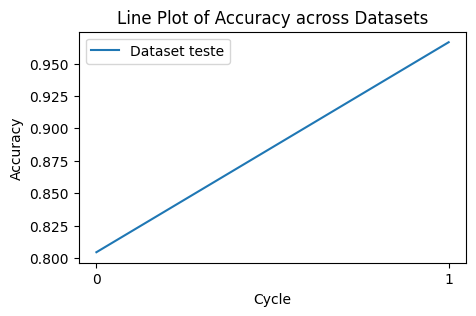

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns

# Create subplots
fig, ax = plt.subplots(figsize=(5, 3))

# Plot accuracy for each dataset
cycle = np.arange(len(listAccuracies))  # Generate cycle values
accuracy = listAccuracies
ax.plot(cycle,accuracy, label=f'Dataset teste')

# cycles
cycles = range(0, len(listAccuracies))

# Set labels and title
ax.set_xlabel('Cycle')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy across Datasets')
ax.set_xticks(cycles)

# Add legend
ax.legend()

# Show plot
plt.show()


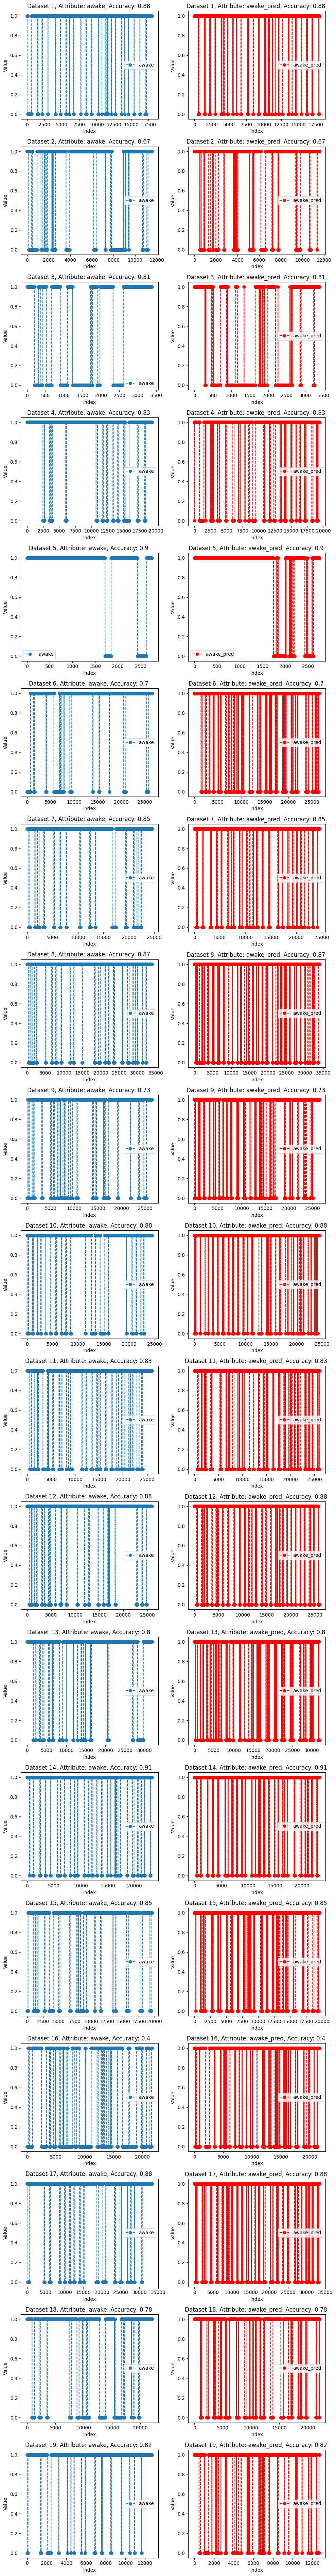

In [31]:
import matplotlib.pyplot as plt
import numpy as np

cycle_s = 0
# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns
data = datasetsMixed[cycle_s] # Your array with 18 datasets
selectedAttributes = ['awake','awake_pred']

# Determine the number of datasets and attributes
num_datasets = len(data)
num_attributes = len(selectedAttributes)  # Assuming all datasets have the same number of attributes

# Calculate the number of rows and columns for subplots
num_rows = num_datasets
num_cols = num_attributes  # Two subplots per attribute

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# Plot each dataset in its own subplot
for i, dataset in enumerate(data):
    for j, attribute in enumerate(selectedAttributes):
        ax = axs[i, j]
        if(j % 2 == 1):
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o', color='red')
        else:
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o')
        ax.set_title(f'Dataset {i+1}, Attribute: {attribute}, Accuracy: {round(metricsAll[cycle_s][i]["accuracy"], 2)} ')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

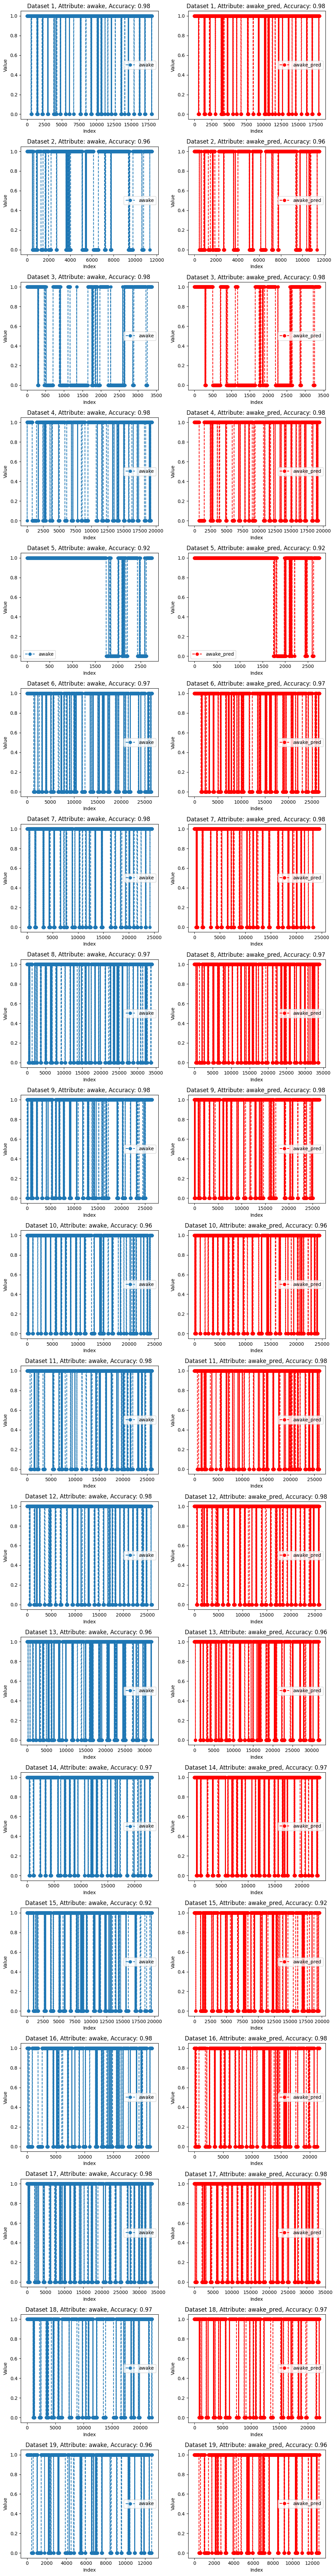

In [33]:
import matplotlib.pyplot as plt
import numpy as np

cycle_s = 1
# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns
data = datasetsMixed[cycle_s] # Your array with 18 datasets
selectedAttributes = ['awake','awake_pred']

# Determine the number of datasets and attributes
num_datasets = len(data)
num_attributes = len(selectedAttributes)  # Assuming all datasets have the same number of attributes

# Calculate the number of rows and columns for subplots
num_rows = num_datasets
num_cols = num_attributes  # Two subplots per attribute

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# Plot each dataset in its own subplot
for i, dataset in enumerate(data):
    for j, attribute in enumerate(selectedAttributes):
        ax = axs[i, j]
        if(j % 2 == 1):
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o', color='red')
        else:
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o')
        ax.set_title(f'Dataset {i+1}, Attribute: {attribute}, Accuracy: {round(metricsAll[cycle_s][i]["accuracy"], 2)} ')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Evaluate models

In [34]:
print("creating model")

def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(9,)),
      #tf.keras.layers.Dense(9, activation=tf.keras.activations.relu), 
      tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(8, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
      #tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
    ])

keras_model = create_keras_model()
#keras_model.summary()
keras_model.summary()

creating model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


2024-02-20 13:38:50.264194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 13:38:50.343103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-02-20 13:38:50.343145: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-02-20 13:38:50.344547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [35]:
checkpointModels_h5 = []

selected_round_checkpoint = NUMBER_OF_ITERATIONS_FINAL

for cycle_index in cycles:
    checkPointFolder = "result_unbalanced_epoch_"+str(NUM_EPOCHS)+"_rounds_"+str(NUMBER_OF_ITERATIONS_FINAL)+"_cycle_"+str(cycle_index)
    checkPointFolder = checkPointFolder + "/checkpoints"

    filename_h5 = checkPointFolder+"/round-"+str(selected_round_checkpoint)+"-weights.h5"

    checkpointModels_h5.append(filename_h5)

In [36]:
checkpointModels_h5

['result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5',
 'result_unbalanced_epoch_1_rounds_200_cycle_1/checkpoints/round-200-weights.h5']

In [38]:
def getMetricUsingCheckpoint(checkpointFileName,inputTestData,inputTestLabels,model = None):
    print("Loading checkpoint: "+checkpointFileName)

    if(model is None):
        keras_model = create_keras_model()
        keras_model.load_weights(checkpointFileName)
    else:
        keras_model = model

    print()
    print("Starting to test")
    # cycle data list
    #trainDataPerCycle = []

    yhat_probs = keras_model.predict(inputTestData,verbose=VERBOSE)

    # as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
    yhat_probs_rounded = yhat_probs.round()

    # create a dataframe with the predicted data
    y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake_pred','asleep_pred']) 

    metrics,metricsa = generateMetrics(y_predicted_df["awake_pred"],inputTestLabels["awake"])
    
    return metrics, y_predicted_df
      

In [39]:
# checkpoint test metrics
metricsTestsPerCycle = []
for checkpoint in checkpointModels_h5:

    metricsTCycle, y_predicted_df = getMetricUsingCheckpoint(checkpoint,X_test_data,y_test_label)

    #trainDataPerCycle.append(metrics)
    print()
    printMetrics(y_predicted_df["awake_pred"],y_test_label["awake"])    
    #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
    print()
    print()

    metricsTestsPerCycle.append(metricsTCycle)

Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.830059
Precision: 0.866172
Recall: 0.920281
F1 score: 0.892407
Cohens kappa: 0.490042
ROC AUC: 0.727647
\Confusion Matrix
[[ 16900 14688][ 8235 95065]]


Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_1/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.831890
Precision: 0.867056
Recall: 0.921693
F1 score: 0.893540
Cohens kappa: 0.495910
ROC AUC: 0.730275
\Confusion Matrix
[[ 17050 14591][ 8085 95162]]




In [ ]:
#    trainData = trainDataPerCycle[cycle]
#    inferredData = inferredDataPerCycle[cycle]

#    dsClient = []
#    for ds in range(0,len(trainData)):
#        client = DataFrame(data=trainData[ds]["awake"], columns=["awake"])
#
#        client["awake_pred"] = inferredData[ds]["awake"]
#        dsClient.append(client)
#    print("Mixed datasets: "+str(len(dsClient)))

In [40]:
metrics = None
metricsa = None
metricsAllLocal = []

for i in range(0,len(datasetsMixed)):
    if(i ==0):
        cycleList = trainDataPerCycle[i]
    else:
        cycleList = inferredDataPerCycle[i-1]
    selectedCheckpoint = checkpointModels_h5[i]
    # load model
    keras_model = create_keras_model()
    keras_model.load_weights(selectedCheckpoint)
    
    print("Clients found: "+str(len(cycleList)))
    
    metricsCycle = []

    for j in range(0,len(cycleList)): 
        print("Selected client: "+str(j))
        client = (cycleList[j])

        local_client_data  = client[inputFeatures]
        local_client_label = client[outputClasses]
    
        metrics, y_predicted_df = getMetricUsingCheckpoint(selectedCheckpoint,local_client_data,local_client_label,keras_model)
        
        metricsCycle.append(metrics)
        print()
        printMetrics(local_client_label["awake"],y_predicted_df["awake_pred"])    
        #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
        print()
        print()

        
    print()
    print("Clients processed: "+str(len(metricsCycle)))
    print()
    metricsAllLocal.append(metricsCycle)

Clients found: 19
Selected client: 0
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.879009
Precision: 0.934265
Recall: 0.932379
F1 score: 0.933321
Cohens kappa: 0.280946
ROC AUC: 0.641734
\Confusion Matrix
[[ 580 1072][ 1105 15236]]


Selected client: 1
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.674336
Precision: 0.751921
Recall: 0.803628
F1 score: 0.776915
Cohens kappa: 0.176492
ROC AUC: 0.584006
\Confusion Matrix
[[ 1240 2163][ 1602 6556]]


Selected client: 2
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.811706
Precision: 0.884636
Recall: 0.795058
F1 score: 0.837459
Cohens kappa: 0.615221
ROC AUC: 0.816407
\Confusion Matrix
[[ 1105 214][ 423 1641]]


Selected client: 3
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/che

In [42]:
len(metricsAllLocal[0])

19

In [43]:
len(metricsAllLocal)

2

In [41]:
metrics = None
metricsa = None
metricsAllLocalOriginal = []

for i in range(0,len(datasetsMixed)):
    trainDataPerCycle[0]

    selectedCheckpoint = checkpointModels_h5[i]
    # load model
    keras_model = create_keras_model()
    keras_model.load_weights(selectedCheckpoint)
    
    print("Clients found: "+str(len(cycleList)))
    
    metricsCycle = []

    for j in range(0,len(cycleList)): 
        print("Selected client: "+str(j))
        client = (cycleList[j])

        local_client_data  = client[inputFeatures]
        local_client_label = client[outputClasses]
    
        metrics, y_predicted_df = getMetricUsingCheckpoint(selectedCheckpoint,local_client_data,local_client_label,keras_model)
        
        metricsCycle.append(metrics)
        print()
        printMetrics(local_client_label["awake"],y_predicted_df["awake_pred"])    
        #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
        print()
        print()

        
    print()
    print("Clients processed: "+str(len(metricsCycle)))
    print()
    metricsAllLocalOriginal.append(metricsCycle)

Clients found: 19
Selected client: 0
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
\Confusion Matrix
[[ 1685 0][ 0 16308]]


Selected client: 1
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
\Confusion Matrix
[[ 2842 0][ 0 8719]]


Selected client: 2
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
\Confusion Matrix
[[ 1528 0][ 0 1855]]


Selected client: 3
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-

In [ ]:
from statistics import mean
print("Print average accuracy among - pred with train")
listAccuracies = []
for i in range(0,len(metricsAllLocalOriginal)): 
    cycleList = metricsAllLocalOriginal[i]


    print("Clients found: "+str(len(cycleList)))
    metricsCycle = []
    for j in range(0,len(cycleList)): 
        #print("Selected client: "+str(j))
        clientMetrics = (cycleList[j]) 

        accuracy = clientMetrics['accuracy']

        metricsCycle.append(accuracy)
    
    print(metricsCycle)
    print(mean(metricsCycle))

    listAccuracies.append(mean(metricsCycle))

Print average accuracy among - pred with train
Clients found: 19
[0.9889401433890957, 0.9827869561456621, 0.9411764705882353, 0.9649285677445975, 0.9625862695241555, 0.9730116309707532, 0.9771337735387625, 0.970504085184202, 0.9769667170953101, 0.9729210913249469, 0.9633358954650268, 0.9769782508098103, 0.9746493897656323, 0.9773274823610394, 0.9605001275835673, 0.9682034242466196, 0.9694997600767754, 0.9519923840609276, 0.9664804469273743]
0.9694696245685523
Clients found: 19
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999213156031159]
0.9999958587159534
Clients found: 19
[0.9939420885900072, 0.9820949744831762, 0.9207803724504877, 0.9801433802671617, 0.9295314202687976, 0.979109421462717, 0.9881796690307328, 0.982036987877179, 0.9818078668683813, 0.9793334422479987, 0.9782090699461953, 0.9869273484497918, 0.9862579612838452, 0.981672689726381, 0.977545292166369, 0.9777562416355162, 0.9875539827255279, 0.9838614624416337, 0.98678102132

In [ ]:
from statistics import mean
print("Print average accuracy among - pred with train")
listAccuracies = []
for i in range(0,len(metricsAll)): 
    cycleList = metricsAll[i]


    print("Clients found: "+str(len(cycleList)))
    metricsCycle = []
    for j in range(0,len(cycleList)): 
        #print("Selected client: "+str(j))
        clientMetrics = (cycleList[j]) 

        accuracy = clientMetrics['accuracy']

        metricsCycle.append(accuracy)
    
    print(metricsCycle)
    print(mean(metricsCycle))

    listAccuracies.append(mean(metricsCycle))

Print average accuracy among - pred with train


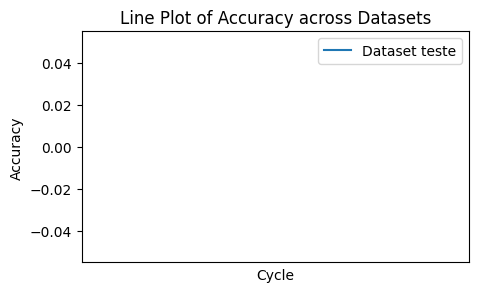

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns

# Create subplots
fig, ax = plt.subplots(figsize=(5, 3))

# Plot accuracy for each dataset
cycle = np.arange(len(listAccuracies))  # Generate cycle values
accuracy = listAccuracies
ax.plot(cycle,accuracy, label=f'Dataset teste')

# cycles
cycles = range(0, len(listAccuracies))

# Set labels and title
ax.set_xlabel('Cycle')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy across Datasets')
ax.set_xticks(cycles)

# Add legend
ax.legend()

# Show plot
plt.show()

In [ ]:
y_test_label

awake  asleep
0        0.0     1.0
1        0.0     1.0
2        0.0     1.0
3        0.0     1.0
4        0.0     1.0
...      ...     ...
23747    1.0     0.0
23748    1.0     0.0
23749    1.0     0.0
23750    1.0     0.0
23751    1.0     0.0

[134888 rows x 2 columns]